In [1]:
import numpy as np

In [19]:
class LogisticRegression :
  def __init__ (self,class_num=1) :
    self.weight = None
    self.bias = None
    self.class_num = class_num
    self.grad_weight = None
    self.grad_bias = None
    self.xhist = None


  def __build_weight (self,features) :
    std_values = np.sqrt(6/(features + 1))
    self.weight = np.random.uniform(
        low=-std_values,high=std_values,size=(features,self.class_num)
    )
    self.bias = np.zeros((1,self.class_num))

  def __call__ (self,x) :
    self.xhist = x
    if self.weight is None or self.bias is None :
      self.__build_weight(x.shape[-1])
    return np.matmul(x,self.weight) + self.bias


  def backwardpass (self,grad) :
    self.grad_weight  = np.matmul(self.xhist.T,grad)
    self.grad_bias = np.sum(grad,axis=0,keepdims=True)

  def get_weight(self) :
    return [self.weight,self.bias]

  def update_weight (self,w) :
    self.weight = w

  def update_bias (self,b) :
    self.bias = b

  def get_grad (self) :
    return [self.grad_weight,self.grad_bias]


In [20]:
def sigmoid (x) :
  return 1 / (1 + np.exp(-x))

In [98]:
class BinaryCatagoricalCrossentropy:
  def __init__(self) :
    self.hist = None
  def __call__ (self,y_true,y_pred) :
    y_pred = sigmoid(y_pred)
    self.hist = y_true.copy(),y_pred.copy()
    n = len(y_true)
    loss = (-1/n) * np.sum(y_true * np.log(y_pred + 1e-6) + (1 - y_true ) * np.log(1 - y_pred + 1e-6) )
    return loss


  def backwardpass(self) :
    y_true,y_pred = self.hist
    n = len(y_true)
    return (y_pred - y_true) / n

class RMSProp :
  def __init__(self,lr= 1e-3,beta = 0.999,clipnorm = 0) :
    self.lr = lr
    self.beta = beta
    self.RMS = None
    self.Model_weight = None
    self.grad = None
    self.epoch = 0
    self.clipnorm = clipnorm

  def apply_weight(self,weight:list) :
    self.Model_weight = weight

  def apply_grad (self,grad : list):
    self.grad = grad

  def build_Component (self) :
    self.RMS = list()
    for w in self.Model_weight :
      self.RMS.append(np.zeros_like(w))

  def __execute (self,w,g,r) :
    rms = self.beta * r + (1 - self.beta) * np.power(g,2)
    w -= self.lr / np.sqrt(rms + 1e-6) * g
    return w,rms

  def step(self) :
    if self.RMS is None :
      self.build_Component()
    for i in range(len(self.Model_weight)) :
      w,r = self.__execute(
        w = self.Model_weight[i],
        g = self.grad[i],
        r= self.RMS[i]
      )
      self.Model_weight[i]  = w
      self.RMS[i] = r
    self.epoch +=1
    return self.Model_weight

In [99]:
class Adam :
  def __init__ (self,lr = 1e-3,beta1=0.9,beta2= 0.999,epsilon = 1e-6,clipnorm=0) :
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.Model_weight = None
    self.grad = None
    self.epoch = 0
    self.clipnorm = clipnorm
    self.rms = None
    self.moment = None
    self.epoch = 0

  def build_Component(self) :
    self.rms = list()
    self.moment = list()
    for w in self.Model_weight :
      self.rms.append(np.zeros_like(w))
      self.moment.append(np.zeros_like(w))

  def apply_weight(self,weight:list) :
    self.Model_weight = weight

  def apply_grad (self,grad : list):
    self.grad = grad

  def execute (self,w,g,m,r) :
    moment = self.beta1 * m + (1 - self.beta1) * g
    rms = self.beta2 * r + (1 - self.beta2) * np.power(g,2)
    moment_hat = moment / (1 - self.beta1 ** (self.epoch + 1))
    rms_hat = rms / (1 - self.beta2 ** (self.epoch + 1))
    w -= self.lr / (np.sqrt(rms_hat + self.epsilon)) * moment_hat
    return w,moment,rms

  def step (self) :
    if self.moment is None or self.rms is None :
      self.build_Component()

    for i in range(len(self.Model_weight)) :
      if self.clipnorm > 0 :
        norm = np.linalg.norm(self.grad[i])
        if norm > self.clipnorm :
          self.grad[i] *= self.clipnorm / norm

      self.Model_weight[i],self.moment[i],self.rms[i] = self.execute(
          self.Model_weight[i],self.grad[i],self.moment[i],self.rms[i]
      )
    self.epoch +=1
    return self.Model_weight

class Momentum :
  def __init__ (self,lr=1e-6,beta = 0.9)  :
    self.lr = lr
    self.beta = beta
    self.momentum = None
    self.Model_weight = None
    self.grad = None

  def build_component (self) :
    self.momentum = list()
    for w in self.Model_weight :
      self.momentum.append(np.zeros_like(w))

  def apply_weight(self,weight:list) :
    self.Model_weight = weight

  def apply_grad (self,grad : list) :
    self.grad = grad

  def execute (self,w,g,m) :
    moment = self.beta * m + (1 - self.beta) * g
    w -= self.lr * moment
    return w,moment

  def step (self) :
    if self.momentum is None :
      self.build_component()

    for i in range(len(self.Model_weight)) :
      self.Model_weight[i],self.momentum[i] = self.execute(
          self.Model_weight[i],self.grad[i],self.momentum[i]
      )

    return self.Model_weight

In [100]:
from sklearn.datasets import make_classification
x_train,y_train = make_classification(n_samples=500,n_classes=2)
y_train = y_train.reshape(-1,1)

In [101]:
linear = LogisticRegression()
loss_fn = BinaryCatagoricalCrossentropy()
optimizer = RMSProp(lr=1e-3)

In [102]:
import matplotlib.pyplot as plt

In [103]:
history = list()
epochs = 500
accuray_hist = list()
for epoch in range(epochs) :
  y_pred = linear(x_train.copy())
  loss = loss_fn(y_train,y_pred)
  gradloss = loss_fn.backwardpass()
  accuray_hist.append(np.mean(np.where(y_pred > 0.5,1,0) == y_train))
  linear.backwardpass(gradloss)
  optimizer.apply_weight(linear.get_weight())
  optimizer.apply_grad(linear.get_grad())
  weight = optimizer.step()
  linear.update_weight(weight[0])
  linear.update_bias(weight[1])
  print(f"epoch : {epoch + 1}/{epochs }loss : {loss}")
  history.append(loss)

epoch : 1/500loss : 1.4265407766752483
epoch : 2/500loss : 1.3343732441359748
epoch : 3/500loss : 1.2709305097238455
epoch : 4/500loss : 1.2205649383818655
epoch : 5/500loss : 1.1781251018617478
epoch : 6/500loss : 1.1411619588102935
epoch : 7/500loss : 1.1082840050237288
epoch : 8/500loss : 1.0786104041354942
epoch : 9/500loss : 1.051541114588106
epoch : 10/500loss : 1.0266449202524615
epoch : 11/500loss : 1.0035990148746778
epoch : 12/500loss : 0.9821538375866353
epoch : 13/500loss : 0.9621113668084518
epoch : 14/500loss : 0.94331107446492
epoch : 15/500loss : 0.925620477044061
epoch : 16/500loss : 0.9089285682531506
epoch : 17/500loss : 0.8931411257370448
epoch : 18/500loss : 0.8781772755859196
epoch : 19/500loss : 0.8639669243566871
epoch : 20/500loss : 0.8504488038760212
epoch : 21/500loss : 0.8375689580943645
epoch : 22/500loss : 0.8252795548429409
epoch : 23/500loss : 0.8135379404123285
epoch : 24/500loss : 0.8023058783524611
epoch : 25/500loss : 0.7915489299455986
epoch : 26/50

In [104]:
linear3 = LogisticRegression()
loss_fn3 = BinaryCatagoricalCrossentropy()
optimizer3 = Adam()

In [105]:
history3 = list()
epochs = 500
accuray_hist3 = list()
for epoch in range(epochs) :
  y_pred = linear3(x_train.copy())
  loss = loss_fn3(y_train,y_pred)
  gradloss = loss_fn.backwardpass()
  accuray_hist3.append(np.mean(np.where(y_pred > 0.5,1,0)== y_train))
  linear3.backwardpass(gradloss)
  optimizer3.apply_weight(linear.get_weight())
  optimizer3.apply_grad(linear.get_grad())
  weight = optimizer.step()
  linear3.update_weight(weight[0])
  linear3.update_bias(weight[1])
  print(f"epoch : {epoch + 1}/{epochs }loss : {loss}")
  history3.append(loss)

epoch : 1/500loss : 1.65110787722779
epoch : 2/500loss : 0.30934090571189904
epoch : 3/500loss : 0.3092374254483531
epoch : 4/500loss : 0.30913413540086493
epoch : 5/500loss : 0.3090310354626104
epoch : 6/500loss : 0.30892812552672644
epoch : 7/500loss : 0.3088254054863109
epoch : 8/500loss : 0.30872287523442304
epoch : 9/500loss : 0.3086205346640843
epoch : 10/500loss : 0.3085183836682779
epoch : 11/500loss : 0.30841642213994963
epoch : 12/500loss : 0.3083146499720082
epoch : 13/500loss : 0.3082130670573253
epoch : 14/500loss : 0.3081116732887361
epoch : 15/500loss : 0.3080104685590397
epoch : 16/500loss : 0.3079094527609989
epoch : 17/500loss : 0.30780862578734114
epoch : 18/500loss : 0.3077079875307586
epoch : 19/500loss : 0.30760753788390854
epoch : 20/500loss : 0.30750727673941364
epoch : 21/500loss : 0.307407203989862
epoch : 22/500loss : 0.30730731952780777
epoch : 23/500loss : 0.3072076232457717
epoch : 24/500loss : 0.3071081150362411
epoch : 25/500loss : 0.30700879479167
epoch

In [106]:
linear2 = LogisticRegression()
loss_fn2 = BinaryCatagoricalCrossentropy()
optimizer2 = Momentum(lr=1e-3)

In [107]:
history2 = list()
epochs = 500
accuray_hist2 = list()
for epoch in range(epochs) :
  y_pred = linear2(x_train.copy())
  loss = loss_fn2(y_train,y_pred)
  gradloss = loss_fn.backwardpass()
  accuray_hist2.append(np.mean(np.where(y_pred > 0.5,1,0)== y_train))
  linear2.backwardpass(gradloss)
  optimizer2.apply_weight(linear.get_weight())
  optimizer2.apply_grad(linear.get_grad())
  weight = optimizer.step()
  linear2.update_weight(weight[0])
  linear2.update_bias(weight[1])
  print(f"epoch : {epoch + 1}/{epochs }loss : {loss}")
  history2.append(loss)

epoch : 1/500loss : 0.5879933086836688
epoch : 2/500loss : 0.27908657005847237
epoch : 3/500loss : 0.2790647315990631
epoch : 4/500loss : 0.2790430301409105
epoch : 5/500loss : 0.2790214655851885
epoch : 6/500loss : 0.2790000378331203
epoch : 7/500loss : 0.2789787467859777
epoch : 8/500loss : 0.2789575923450818
epoch : 9/500loss : 0.2789365744118024
epoch : 10/500loss : 0.2789156928875588
epoch : 11/500loss : 0.2788949476738194
epoch : 12/500loss : 0.2788743386721017
epoch : 13/500loss : 0.27885386578397264
epoch : 14/500loss : 0.27883352891104835
epoch : 15/500loss : 0.27881332795499475
epoch : 16/500loss : 0.2787932628175268
epoch : 17/500loss : 0.27877333340040933
epoch : 18/500loss : 0.2787535396054565
epoch : 19/500loss : 0.27873388133453236
epoch : 20/500loss : 0.2787143584895506
epoch : 21/500loss : 0.2786949709724745
epoch : 22/500loss : 0.2786757186853173
epoch : 23/500loss : 0.2786566015301421
epoch : 24/500loss : 0.278637619409062
epoch : 25/500loss : 0.2786187722242398
epoc

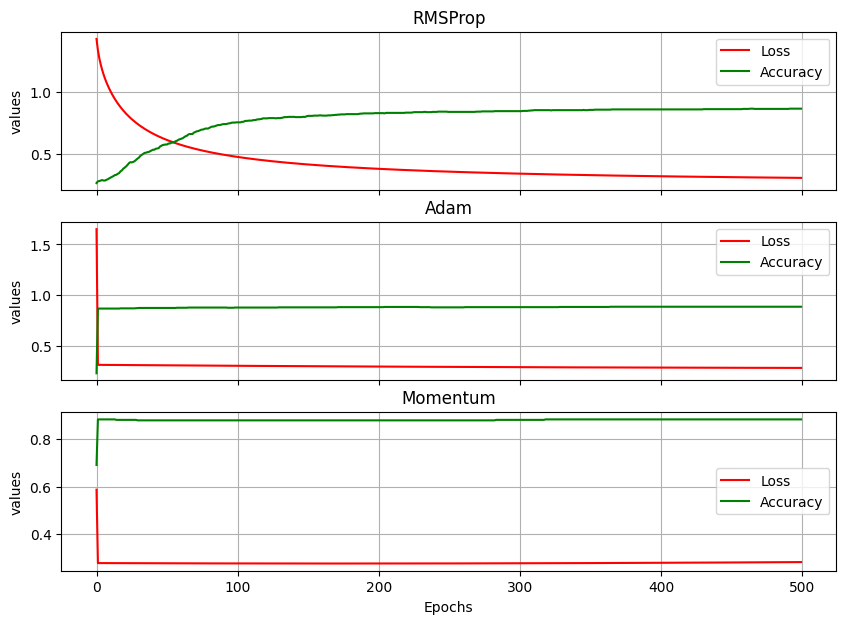

In [110]:
fig,axs = plt.subplots(3,1,figsize = (10,7),sharex=True)
optimizers_name = ["RMSProp","Adam","Momentum"]
accuracy = [accuray_hist,accuray_hist3,accuray_hist2]
loss = [history,history3,history2]

for i  in range(3) :
  axs[i].set_title(optimizers_name[i])
  axs[i].set_ylabel("values")
  axs[i].plot(loss[i],label="Loss",color='red')
  axs[i].plot(accuracy[i],label="Accuracy",color='green')
  axs[i].grid(True)
  axs[i].legend()
plt.xlabel("Epochs")
plt.show()
